In [30]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from fceu_help import pointer_to_numpy
import scipy
import scipy.misc
import cv2

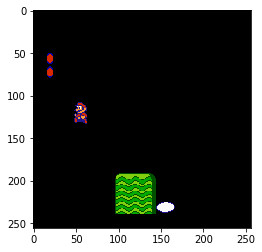

In [43]:
#rom = "mario.nes"

#movie = 'happylee4-smb-warpless.fm2'

rom = "mario.nes"
movie = "mario.fm2"
start_t = 373
# rom = "metroid.nes"
#movie = "metroid.fm2"
# start_t = 300
# movie ='lordtom-metroid-100.fm2'
#movie = "metroid-long.fm2"

#rom = 'zelda.nes'
#movie = 'baxter,jprofit22-legendofzelda.fm2'
#movie = 'zelda.fm2'

rom = 'zelda.nes'
movie = 'taseditorv1-legendofzelda-allitems.fm2'
start_t = 900

# rom = "ff.nes"
# movie = 'theaxemanv4-finalfantasy.fm2'
# start_t = 10

#rom = 'dw.nes'
#movie = 'acmlm-dragonwarrior.fm2'
#start_t = 120

rom = "smb2u.nes"
movie = "smb2u-2.fm2"
start_t = 450
emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

for i,i2 in zip(inputs1[:start_t],inputs2[:start_t]):
    emu.stepFull(i, i2)
    
 
def convert_image(img_buffer):
    # TODO: without allocations/reshape?
    screen = pointer_to_numpy(img_buffer)
    return screen.reshape([256, 256, 4]).astype(np.uint8)

img_buffer = fceulib.VectorBytes()
emu.imageInto(img_buffer)
np_image = convert_image(img_buffer)
plt.imshow(np_image)
plt.show()

# img = Image.fromarray(scipy.misc.imresize(np_image,1.0))
# print tesserocr.image_to_text(img) 
    

In [44]:
emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

start = 450
end = len(inputs1)

for i,i2 in zip(inputs1[:start_t],inputs2[:start_t]):
    emu.stepFull(i, i2)

for t in range(start_t, end):
    emu.stepFull(inputs1[t], inputs2[t])
    emu.imageInto(img_buffer)
    np_image = convert_image(img_buffer)
    cv2.imwrite("../fami/out/frames/smb2_"+str(t)+".png", cv2.cvtColor(np_image,cv2.COLOR_RGB2BGR))

In [ ]:
%%time

reload(ppu_dump)

end = 3900
#METROID
#scroll_area= (0,0,32,30-0)

#ZELDA
#scroll_area= (0,8,32,30-8)

#MARIO, ZELDA2
#scroll_area = (0, 4, 32, 30-4)

ep_data = ppu_dump.ppu_output(emu,
                              inputs1[start_t:end],
                              inputs2=inputs2[start_t:end],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=True,
                              colorized_tiles=False,
                              display=False,
                              test_control=True,
                              peekevery=2,
                            scroll_area= scroll_area )

In [ ]:

from collections import Counter
posx, posy = 0, 0
nt_total = {}
potential_nt_total = {}
nt_totals = [nt_total]
tilex = 0
tiley = 0
interstitial = False
prev = None
curr = None
gap =10
big_gap = 60
timeSinceControl = 0
thresh =1
accum = 0
screen_offsets = {}
room_v_time = {}
accumX = 0
accumY = 0
potential_interstitial = False
correlation_threshold = 0.1
for t, (sx, sy) in sorted(ep_data["tilemap_motion"].items()):
    if t not in ep_data['screen_corrs']:
        ep_data['screen_corrs'][t] = 1
        print  t
    #print t, len(ep_data["nametables"])
    nt = ep_data["nametables"][t]
    attr = ep_data["attr"][t]
    pal = ep_data['palettes'][t]
    if sx >= 16:
        sx -= 32
    if sx <= -16:
        sx += 32
    if sy >= 15:
        sy -= 30
    if sy <= -15:
        sy += 30
    
    tilex += sx
    tiley += sy
    screen_offsets[t] = (tilex,tiley)
    if not ep_data['has_controls'][t]:
        timeSinceControl += 1
    else:
        timeSinceControl  = 0
        accumX = 0
        accumY = 0
    if timeSinceControl > 0:
        accumX += sx
        accumY += sy
    if timeSinceControl > gap and ((abs(accumX) >= scroll_area[2]/2 or
                                    abs(accumY) >= scroll_area[3]/2) or 
                                   timeSinceControl > big_gap):
        if not interstitial:
            #print t, timeSinceControl
            #plt.imshow(nt)
            #plt.show()
            pass
        interstitial = True
        potential_nt_total = {}
        potential_interstitial = False
    elif timeSinceControl > gap:
        potential_interstitial  = True
    else:
        if potential_interstitial:
            for key in potential_nt_total:
                if key not in nt_total:
                    nt_total[key] = {}
                for t in potential_nt_total[key]:
                    nt_total[key][t] = potential_nt_total[key][t]
            potential_nt_total = {}
            potential_interstitial = False
    #print t, timeSinceControl
    if  not (interstitial or potential_interstitial) :
        #print "t", t, "scroll by", sx, sy, tilex, tiley
        for x in range(0, scroll_area[2]):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in nt_total:
                    nt_total[key] = {}
                nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    if potential_interstitial:
        for x in range(0, scroll_area[2]):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in potential_nt_total:
                    potential_nt_total[key] = {}
                potential_nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    
    if (ep_data['screen_corrs'][t]<correlation_threshold) and ep_data['screen_corrs'][t] > 0:
        print t, ep_data['screen_corrs'][t]
        interstitial = True
    prev = curr
    curr = {}
    diff = 0
    for x in range(0, scroll_area[2]):
        for y in range(0, scroll_area[3]):
            key = (y+tiley, x+tilex)
            if key not in curr:
                curr[key] = (int(nt[y, x]),int(attr[y, x]))
            if prev:
                if key not in prev:
                    diff += 1
                elif curr[key] != prev[key]:
                    diff += 1  
    if (diff > scroll_area[2]*scroll_area[3]*thresh):
        interstitial = True
    #print t, timeSinceControl,interstitial,potential_interstitial,float(diff)/float(scroll_area[2]*scroll_area[3]),accumX,accumY
    
    if ((ep_data['has_controls'][t] and interstitial) or (diff > scroll_area[2]*scroll_area[3]*thresh)) and (ep_data['screen_corrs'][t]>correlation_threshold):
        #print t,float(diff)/float(scroll_area[2]*scroll_area[3]) , 'REGAINED CONTROL'
       
        plt.imshow(nt)
        plt.show()
        timeSinceControl  = 0
        interstitial = False
        #plt.imshow(nt)
        #plt.show()
        interstitial = False
        nt_total = {}
        nt_totals.append(nt_total)
    room_v_time[t] = len(nt_totals)-1
    
    
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
        colorized = ep_data["tile2colorized"]
        out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
        for x in range(0, maxx-minx):
            for y in range(0, maxy-miny):
                col = np.zeros(shape=(8,8,3))
                if (y,x) in nt_result:
                    ind_per_tile = nt_result[y,x].values()
                    i2c = {}
                    for i in ind_per_tile:
                        if i not in i2c:
                            i2c[i] = 0
                        i2c[i] += 1
                    
                    #ind = sorted(nt_result[y, x])

                    #ind = ind[int(len(ind)/4.0)]
                    col = colorized[sorted(i2c.iteritems(), key=lambda (k,v): (v,k))[-1][0]]  # Returns the highest occurring item
                    
                    #col = colorized[nt_result[y, x][ind]]
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
        plt.figure(figsize=(20,10)) 
        plt.imshow(out_image)
        plt.savefig('{}.png'.format(nt_id))
        plt.show()

In [ ]:
from unionfind import UnionFind
print ep_data['screen_corrs']

In [ ]:
def room2attr(room):
    
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1
    attr_room = np.zeros((maxy-miny,maxx-minx,2))
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in room:
                ind = sorted(room[y, x])[0]
                attr_room[int(y-miny), int(x-minx),:] = np.array(room[(y, x)][ind][:-1])
    return attr_room
unions = UnionFind()

def dict_compare(d1, d2):
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    intersect_keys = d1_keys.intersection(d2_keys)
    added = d1_keys - d2_keys
    removed = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in intersect_keys if d1[o] != d2[o]}
    same = set(o for o in intersect_keys if d1[o] == d2[o])
    return added, removed, modified, same

for room_id,room in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1

    for other_id,other in enumerate(nt_totals):
        if len(room) > 0 and len(other) > 0:
            if room2attr(room).shape == room2attr(other).shape:
                if np.sum(np.abs(room2attr(room)-room2attr(other))) == 0:
                    unions.union(room_id,other_id)

            
cluster2room = {}

for u in unions:
    if unions[u] not in cluster2room:
        cluster2room[unions[u]] = set()
    cluster2room[unions[u]].add(u)
print 'digraph G{\n\trankdir=LR;\npenwidth=10;\nnode[shape=none];\n'

for cluster in cluster2room:
    print '\tsubgraph cluster_{} {{'.format(cluster)
    print '\t\tcolor=blue;'
    for room in cluster2room[cluster]:
        print '\t\t n{}[image="{}.png", label="{}", fontsize=240,fontcolor=red];'.format(room,room,room);
    print '\t}'
for ii in range(1,len(nt_totals)):
    print 'n{} -> n{} [penwidth=10];'.format(ii-1,ii)
print '}'

In [ ]:
%%time
import tracking
reload(tracking)
tracks, old_tracks = tracking.tracks_from_sprite_data(ep_data['sprite_data'])
for track in tracks:
    old_tracks.append((track,tracks[track]))

In [ ]:
%%time
for room_id, nt_total in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,nt_total.keys()))
    maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
    miny = min(map(lambda (y, x): y,nt_total.keys()))
    maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
    print room_id, (minx+maxx)/2, (miny+maxy)/2
    nt_result = {}
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in nt_total:
                nt_result[y-miny, x-minx] = nt_total[(y, x)]
    colorized = ep_data["tile2colorized"]
    out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
    for x in range(0, maxx-minx):
        for y in range(0, maxy-miny):
            col = np.zeros(shape=(8,8,3))
            if (y,x) in nt_result:
                ind = sorted(nt_result[y, x])
                ind = ind[int(len(ind)/4)]

                col = colorized[nt_result[y, x][ind]]
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
    plt.figure(figsize=(out_image.shape[1]/25,out_image.shape[0]/25)) 
    #plt.imshow(out_image)
    
    for track in old_tracks:
        
        track_id = track[0]
        track = track[1]
        t0 = sorted(track)[4]
        if room_v_time[t0] == room_id:
            p0 = np.zeros(2)
            p0[0] = track[t0][0][0]
            p0[1] = track[t0][0][1]
            p0[0] += screen_offsets[t0][0]*8-(scroll_area[0]+minx)*8
            p0[1] += screen_offsets[t0][1]*8-(scroll_area[1]+miny)*8
            for sub_sprite in track[t0][2]:
                
                img = ep_data['id2colorized'][sub_sprite[0]]
                left = int(screen_offsets[t0][0]*8-(scroll_area[0]+minx)*8+sub_sprite[1][0])
                top =  int(screen_offsets[t0][1]*8-(scroll_area[1]+miny)*8+sub_sprite[1][1])
                for py in range(img.shape[0]):
                    for px in range(img.shape[1]):
                        if img[py,px,0] > 0 and py+top >= 0 and py+top < out_image.shape[0] and px+left >= 0 and px+left < out_image.shape[1]:
                            out_image[py+top,px+left,:-1] = img[py,px,:-1]/255.0
           
            #plt.plot(p0[0],240-p0[1],'ro')
    plt.imshow(out_image)
    plt.savefig("{}.png".format(room_id),bbox_inches='tight')
    plt.show()
    

In [ ]:
print 